In [6]:
# !kill -9 - 621098
!nvidia-smi

Wed Apr  2 05:07:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:03:00.0 Off |                    0 |
| N/A   53C    P0             247W / 400W |   9016MiB / 40960MiB |    100%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
# %%
import os
import jax

# 设置环境变量
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'

import netket as nk
import jax
print("启用分片模式：", nk.config.netket_experimental_sharding)
print("可用设备：", jax.devices())

启用分片模式： True
可用设备： [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [3]:
# %%
import os
import logging
import sys
import jax
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import netket.nn as nknn
import flax
import flax.linen as nn
import jax.numpy as jnp
import math
from math import pi
from functools import partial
from netket.nn import log_cosh
from einops import rearrange
from netket.utils.group.planar import rotation, reflection_group, D, glide, glide_group, C
from netket.utils.group import PointGroup, Identity, PermutationGroup
from netket.operator.spin import sigmax, sigmay, sigmaz
from netket.optimizer.qgt import QGTJacobianPyTree, QGTJacobianDense, QGTOnTheFly
from netket.operator import AbstractOperator
from netket.vqs import VariationalState
from scipy import sparse as _sparse
from netket.utils.types import DType as _DType
from netket.hilbert import DiscreteHilbert as _DiscreteHilbert
from netket.operator import LocalOperator as _LocalOperator
from tqdm.notebook import tqdm
from jax import tree
from netket.nn.blocks import SymmExpSum

In [4]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from functools import partial
from einops import rearrange

def roll(J, shift, axis=-1):
    return jnp.roll(J, shift, axis=axis)

@partial(jax.vmap, in_axes=(None, 0, None), out_axes=1)
@partial(jax.vmap, in_axes=(None, None, 0), out_axes=1)
def roll2d(spins, i, j):
    side = int(spins.shape[-1] ** 0.5)
    spins = spins.reshape(spins.shape[0], side, side)
    spins = jnp.roll(jnp.roll(spins, i, axis=-2), j, axis=-1)
    return spins.reshape(spins.shape[0], -1)

class FMHA(nn.Module):
    d_model: int
    h: int
    L_eff: int
    transl_invariant: bool = True
    two_dimensional: bool = False

    def setup(self):
        self.v = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                          param_dtype=jnp.float64, dtype=jnp.float64)
        if self.transl_invariant:
            self.J = self.param("J", nn.initializers.xavier_uniform(), (self.h, self.L_eff), jnp.float64)
            if self.two_dimensional:
                sq_L_eff = int(self.L_eff ** 0.5)
                assert sq_L_eff * sq_L_eff == self.L_eff
                self.J = roll2d(self.J, jnp.arange(sq_L_eff), jnp.arange(sq_L_eff))
                self.J = self.J.reshape(self.h, -1, self.L_eff)
            else:
                self.J = jax.vmap(roll, (None, 0), out_axes=1)(self.J, jnp.arange(self.L_eff))
        else:
            self.J = self.param("J", nn.initializers.xavier_uniform(), (self.h, self.L_eff, self.L_eff), jnp.float64)

        self.W = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                          param_dtype=jnp.float64, dtype=jnp.float64)

    def __call__(self, x):
        v = self.v(x)
        v = rearrange(v, 'batch L_eff (h d_eff) -> batch L_eff h d_eff', h=self.h)
        v = rearrange(v, 'batch L_eff h d_eff -> batch h L_eff d_eff')
        x = jnp.matmul(self.J, v)
        x = rearrange(x, 'batch h L_eff d_eff -> batch L_eff h d_eff')
        x = rearrange(x, 'batch L_eff h d_eff -> batch L_eff (h d_eff)')
        x = self.W(x)
        return x

def extract_patches1d(x, b):
    return rearrange(x, 'batch (L_eff b) -> batch L_eff b', b=b)

def extract_patches2d(x, b):
    batch = x.shape[0]
    sq_L_eff = int((x.shape[1] // b**2)**0.5)
    x = x.reshape(batch, sq_L_eff, b, sq_L_eff, b)   # [batch, L_eff, b, L_eff, b]
    x = x.transpose(0, 1, 3, 2, 4)              # [batch, L_eff, L_eff, b, b]
    x = x.reshape(batch, sq_L_eff, sq_L_eff, -1)        # flatten patches: [batch, L_eff, L_eff, b*b]
    x = x.reshape(batch, sq_L_eff*sq_L_eff, -1)         # [batch, L_eff*L_eff, b*b]
    return x

def log_cosh(x):
    sgn_x = -2 * jnp.signbit(x.real) + 1
    x = x * sgn_x
    return x + jnp.log1p(jnp.exp(-2.0 * x)) - jnp.log(2.0)

class EncoderBlock(nn.Module):
    d_model: int
    h: int
    L_eff: int
    transl_invariant: bool = True
    two_dimensional: bool = True

    def setup(self):
        self.attn = FMHA(d_model=self.d_model, h=self.h, L_eff=self.L_eff,
                         transl_invariant=self.transl_invariant, two_dimensional=self.two_dimensional)
        self.layer_norm_1 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.layer_norm_2 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.ff = nn.Sequential([
            nn.Dense(4 * self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                     param_dtype=jnp.float64, dtype=jnp.float64),
            nn.gelu,
            nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                     param_dtype=jnp.float64, dtype=jnp.float64),
        ])

    def __call__(self, x):
        x = x + self.attn(self.layer_norm_1(x))
        x = x + self.ff(self.layer_norm_2(x))
        return x

class Encoder(nn.Module):
    num_layers: int
    d_model: int
    h: int
    L_eff: int
    transl_invariant: bool = True
    two_dimensional: bool = True

    def setup(self):
        self.layers = [EncoderBlock(d_model=self.d_model, h=self.h, L_eff=self.L_eff,
                                      transl_invariant=self.transl_invariant, two_dimensional=self.two_dimensional)
                       for _ in range(self.num_layers)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class OuputHead(nn.Module):
    d_model: int
    complex: bool = True

    def setup(self):
        self.out_layer_norm = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm0 = nn.LayerNorm(use_scale=True, use_bias=True, dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm1 = nn.LayerNorm(use_scale=True, use_bias=True, dtype=jnp.float64, param_dtype=jnp.float64)
        self.output_layer0 = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=jax.nn.initializers.zeros,
                                      param_dtype=jnp.float64, dtype=jnp.float64)
        self.output_layer1 = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=jax.nn.initializers.zeros,
                                      param_dtype=jnp.float64, dtype=jnp.float64)

    def __call__(self, x):
        z = self.out_layer_norm(x.sum(axis=1))
        amp = self.norm0(self.output_layer0(z))
        if self.complex:
            sign = self.norm1(self.output_layer1(z))
            out = amp + 1j * sign
        else:
            out = amp
        return jnp.sum(log_cosh(out), axis=-1)

class ViTFNQS(nn.Module):
    num_layers: int
    d_model: int
    heads: int
    n_sites: int         # 总格点数
    patch_size: int      # patch 尺寸
    complex: bool = False
    transl_invariant: bool = True
    two_dimensional: bool = True

    def setup(self):
        if self.two_dimensional:
            self.L_eff = self.n_sites // (self.patch_size ** 2)
        else:
            self.L_eff = self.n_sites // self.patch_size

        self.embed = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                              param_dtype=jnp.float64, dtype=jnp.float64)

        self.encoder = Encoder(
            num_layers=self.num_layers,
            d_model=self.d_model,
            h=self.heads,
            L_eff=self.L_eff,
            transl_invariant=self.transl_invariant,
            two_dimensional=self.two_dimensional
        )
        self.output = OuputHead(self.d_model, complex=self.complex)

    def __call__(self, spins):
        x = jnp.atleast_2d(spins)
        if self.two_dimensional:
            x = extract_patches2d(x, self.patch_size)
        else:
            x = extract_patches1d(x, self.patch_size)
        
        # 直接进入嵌入和编码器模块
        x = self.embed(x)
        x = self.encoder(x)
        out = self.output(x)
        return out

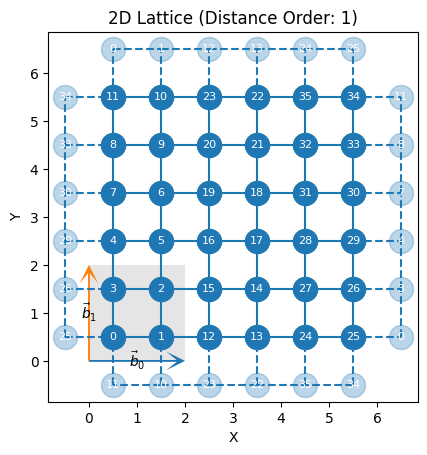

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [ ]:
# %%
# 哈密顿量参数
J1 = 0.8
J2 = 1.0
Q = 0  # 四自旋相互作用强度，替换h项

# Shastry-Sutherland晶格定义
Lx = 3
Ly = 3

# 自定义边
custom_edges = [
    (0, 1, [1.0, 0.0], 0),
    (1, 0, [1.0, 0.0], 0),
    (1, 2, [0.0, 1.0], 0),
    (2, 1, [0.0, 1.0], 0),
    (3, 2, [1.0, 0.0], 0),
    (2, 3, [1.0, 0.0], 0),
    (0, 3, [0.0, 1.0], 0),
    (3, 0, [0.0, 1.0], 0),
    (2, 0, [1.0, -1.0], 1),
    (3, 1, [1.0, 1.0], 1),
]

# 创建晶格
lattice = nk.graph.Lattice(
    basis_vectors=[[2.0, 0.0], [0.0, 2.0]],
    extent=(Lx, Ly),
    site_offsets=[[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]],
    custom_edges=custom_edges,
    pbc=[True, True]
)

# 可视化晶格
lattice.draw()

# %%
# Hilbert空间定义
hi = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 自旋-1/2矩阵
sigmax = jnp.array([[0, 0.5], [0.5, 0]])
sigmay = jnp.array([[0, -0.5j], [0.5j, 0]])
sigmaz = jnp.array([[0.5, 0], [0, -0.5]])
unitm = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# 自旋-自旋相互作用
sxsx = np.kron(sigmax, sigmax)
sysy = np.kron(sigmay, sigmay)
szsz = np.kron(sigmaz, sigmaz)
umum = np.kron(unitm, unitm)
SiSj = sxsx + sysy + szsz

# Q项需要的C_ij算子定义
Cij = 0.25 * umum - SiSj
Cij2 = np.kron(Cij, Cij)  # 四自旋交互项

# 构建J1-J2部分的哈密顿量
bond_operator = [
    (J1 * SiSj).tolist(),
    (J2 * SiSj).tolist(),
]
bond_color = [0, 1]

# 创建图哈密顿量 - 不包含Q项
H_J = nk.operator.GraphOperator(hi, graph=lattice, bond_ops=bond_operator, bond_ops_colors=bond_color)

# 创建Q项哈密顿量
H_Q = nk.operator.LocalOperator(hi, dtype=jnp.complex128)

# 添加四自旋Q项 - 每个单元格(plaquette)上的四自旋相互作用
for unit_x in range(Lx):
    for unit_y in range(Ly):
        # 找到单元格中的4个顶点
        base_idx = 4 * (unit_x + unit_y * Lx)
        plaq_sites = [
            base_idx,                  # 左下角 (0.5, 0.5) 
            base_idx + 1,              # 右下角 (1.5, 0.5)
            base_idx + 2,              # 右上角 (1.5, 1.5)
            base_idx + 3               # 左上角 (0.5, 1.5)
        ]
        
        # 两种不同的顺序添加四自旋相互作用Q项
        # 按照顺时针方向连接
        sites_clockwise = [plaq_sites]
        operatorQ = [(-Q * Cij2).tolist()]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_clockwise)
        
        # 按照交叉方向连接
        sites_cross = [[plaq_sites[0], plaq_sites[2], plaq_sites[1], plaq_sites[3]]]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_cross)

# 合并两部分哈密顿量
ha = H_J + H_Q
ha = ha.to_jax_operator()

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax import tree_util
from tqdm.notebook import tqdm
from netket.experimental.driver.vmc_srt import VMC_SRt

# 定义熵梯度计算函数
def T_logp2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * jnp.mean(jnp.real(preds)**2)

def T_logp_2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * (jnp.mean(jnp.real(preds)))**2

# 基于 VMC_SRt 实现自由能 F = E - T*S 的优化
class FreeEnergyVMC_SRt(VMC_SRt):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 记录初始温度，用于后续温度递减计算
        self.init_temperature = temperature
        self.temperature = temperature

    def _step_with_state(self, state):
        # 基础能量梯度更新步骤
        new_state = super()._step_with_state(state)
        params = new_state.parameters
        inputs = new_state.samples
        
        # 计算熵梯度部分
        mT_grad_S_1 = jax.grad(T_logp2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S_2 = jax.grad(T_logp_2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S = tree_util.tree_map(lambda x, y: x - y, mT_grad_S_1, mT_grad_S_2)
        
        # 自由能梯度：能量梯度减去熵梯度
        total_grad = tree_util.tree_map(lambda g_e, g_s: g_e - g_s, new_state.gradient, mT_grad_S)
        
        # 更新参数
        new_params = self.optimizer.update(total_grad, params)
        new_state = new_state.replace(parameters=new_params)
        return new_state

# 添加进度条以及温度递减方案
class CustomFreeEnergyVMC_SRt(FreeEnergyVMC_SRt):
    def __init__(self, reference_energy, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reference_energy = reference_energy

    def run(self, n_iter, out=None):
        """运行优化并在 tqdm 进度条中显示 Temperature，Energy，E_var，E_err 和 Rel_err(%)"""
        outer_pbar = tqdm(total=n_iter, desc=f"Lx={Lx}, Ly={Ly}")
        for i in range(n_iter):
            # 更新温度：使用初始温度乘以递减因子
            self.temperature = self.init_temperature * (jnp.exp(-i / 50.0) / 2.0)
            self.advance(1)

            energy_mean = self.energy.mean
            energy_var = self.energy.variance
            energy_error = self.energy.error_of_mean
            relative_error = abs((energy_mean - self.reference_energy) / self.reference_energy) * 100

            outer_pbar.set_postfix({
                'Temp': f'{self.temperature:.4f}',
                'Energy': f'{energy_mean:.6f}', 
                'E_var': f'{energy_var:.6f}',
                'E_err': f'{energy_error:.6f}',
                'Rel_err(%)': f'{relative_error:.4f}',
            })
            outer_pbar.update(1)
        outer_pbar.close()
        return self

In [ ]:
# 假设 lattice, hi, hamiltonian, model_no_symm, reference_energy 已经定义
n_samples = 2**12       # 采样数量
chunk_size = 2**10       # 批处理大小
learning_rate = 0.05
diag_shift = 0.001

# 创建采样器
sampler = nk.sampler.MetropolisExchange(hilbert=hi, graph=lattice, n_chains=2**12, d_max=2)
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

In [ ]:
model_no_symm = CTWFNQS(
    num_layers=2,
    d_model=18,      # token embedding dimension = c=18
    h=2,             # 注意力头数=2，每头token维度 = 9
    n_sites=lattice.n_nodes,
    patch_size=2,
    complex_out=True,
    two_dimensional=True
)

In [ ]:
reference_energy=-16.18

In [ ]:
print("\n========== 阶段1: 无对称性约束 ==========")
# 创建只有恒等操作的对称性组
identity_group = PermutationGroup([Identity()], degree=lattice.n_nodes)

# 使用SymmExpSum包装基础模型，只有恒等操作
model_stage1 = SymmExpSum(
    module=model_no_symm, 
    symm_group=identity_group,
    character_id=None
)

vqs1 = nk.vqs.MCState(
    sampler=sampler,
    model=model_stage1,
    n_samples=n_samples,
    n_discard_per_chain=0,  # 丢弃初始样本以减少自相关性
    chunk_size=chunk_size,
    training_kwargs={"holomorphic": False}
)

# 假设已经定义了 CustomVMC_SRt 类，用于自定义变分 Monte Carlo 优化，可以直接使用
vmc1 = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    hamiltonian=ha,
    optimizer=optimizer,
    diag_shift=diag_shift,
    variational_state=vqs1,
    temperature=1.0
)

vmc1.run(n_iter=1000)
energy1 = vmc1.energy.mean.real
print(f"阶段1完成，能量: {energy1:.6f}")


In [ ]:
print("\n========== 阶段2: 添加平移对称性 ==========")
# 创建具有平移对称性的对称群
trans_symmetry = lattice.translation_group()
print("平移对称群元素数量:", len(trans_symmetry))

model_trans = SymmExpSum(
    module=model_no_symm, 
    symm_group=trans_symmetry,
    character_id=None
)

vqs2 = nk.vqs.MCState(
    sampler=sampler,
    model=model_trans,
    n_samples=n_samples,
    n_discard_per_chain=10,  # 较少的丢弃样本
    chunk_size=chunk_size,
    training_kwargs={"holomorphic": False}
)

# 尝试直接复制阶段1的参数到阶段2

vqs2.parameters = vqs1.parameters
print("成功复制阶段1参数到阶段2")


vmc2 = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    hamiltonian=ha,
    optimizer=optimizer,
    diag_shift=diag_shift,
    variational_state=vqs2,
    temperature=1.0
)

vmc2.run(n_iter=400)
energy2 = vmc2.energy.mean.real
print(f"阶段2完成，能量: {energy2:.6f}")


In [ ]:
print("\n========== 阶段3: 添加D4对称性 ==========")
# 使用内置的 C4 对称群
from netket.utils.group import C  # 引入 C4 旋转操作
d4_group = D(4)

# 定义新的对称中心
new_origin = np.array([3.0, 3.0])

# 调整对称群，以 new_origin 为新的旋转中心
new_d4_group = d4_group.change_origin(new_origin)
D4_symmetry = lattice.point_group(new_d4_group)
print("C4对称群元素数量:", len(D4_symmetry))

model_c4 = SymmExpSum(
    module=model_no_symm, 
    symm_group=D4_symmetry,
    character_id=None
)

vqs3 = nk.vqs.MCState(
    sampler=sampler,
    model=model_c4,
    n_samples=n_samples,
    n_discard_per_chain=10,
    chunk_size=chunk_size,
    training_kwargs={"holomorphic": False}
)

# 尝试复制阶段2的参数到阶段3
try:
    vqs3.parameters = vqs2.parameters
    print("成功复制阶段2参数到阶段3")
except Exception as e:
    print(f"参数复制失败，使用随机初始化: {str(e)}")

vmc3 = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    stage_name="3 (C4对称性)",
    hamiltonian=ha,
    optimizer=optimizer,
    diag_shift=diag_shift,
    variational_state=vqs3,
    temperature=1.0,
    stability_window=30,
    stability_threshold=0.0005
)

vmc3.run(n_iter=200)
energy3 = vmc3.energy.mean.real
print(f"阶段3完成，能量: {energy3:.6f}")
# 阶段:阶段1（无对称性）:100% 1000/1000 [1:07:19<00:00, 4.03s/it, Temp=0.0000, Energy=-16.148373, E_var=0.274781, E_err=0.008191, Rel_err(%)=0.6975]
# 阶段:阶段2（平移对称性）:100% 400/400 [57:48<00:00, 8.65s/it, Temp=0.0002, Energy=-16.225645, E_var=0.095039, E_err=0.004817, Rel_err(%)=0.2223]
#阶段:阶段3（C4旋转对称性）:36% 72/200 [09:34<16:46, 7.86s/it, Temp=0.1209, Energy=-16.050443, E_var=0.474660, E_err=0.010765, Rel_err(%)=1.2997]

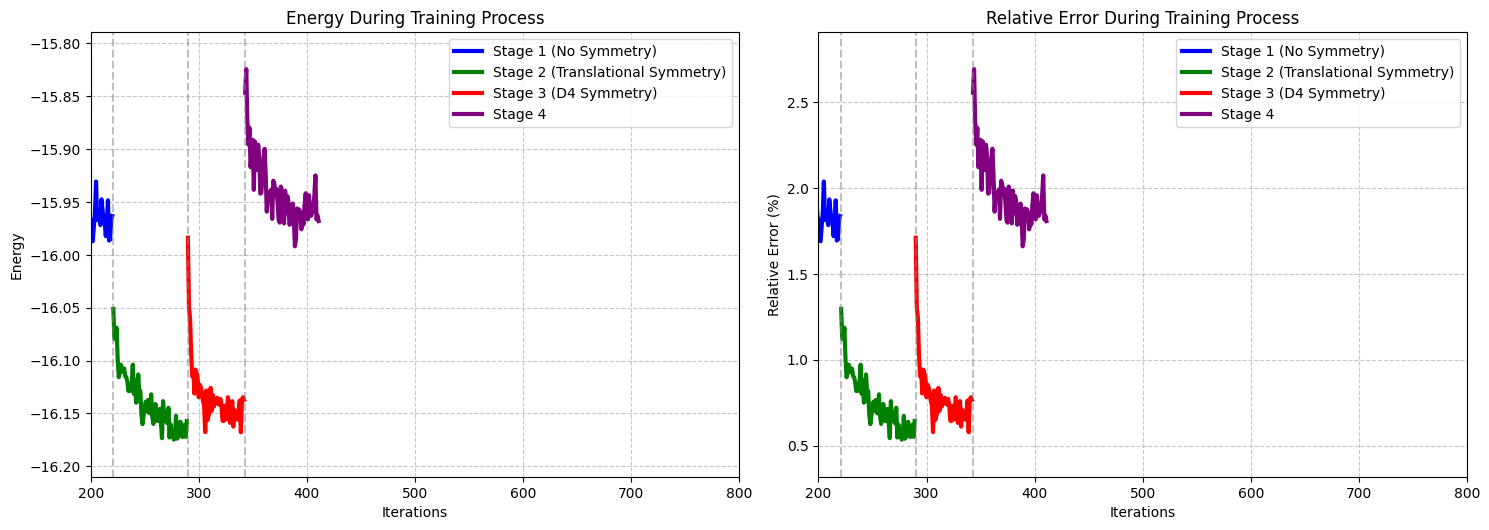

In [ ]:
def plot_training_history(history, iter_min=None, iter_max=None, line_width=2.5, y_margin_percent=5):
    """
    Plot the training history across different stages with continuous iterations.
    
    Args:
        history: Dictionary containing training data for each stage
        iter_min: Minimum iteration to display (optional)
        iter_max: Maximum iteration to display (optional)
        line_width: Width of the plotted lines
        y_margin_percent: Add this percentage margin to y-axis limits for better visualization
    """
    plt.figure(figsize=(15, 10))
    
    # Define stage colors and labels
    stage_colors = {'stage1': 'blue', 'stage2': 'green', 'stage3': 'red', 'stage4': 'purple'}
    stage_names = {
        'stage1': 'Stage 1 (No Symmetry)', 
        'stage2': 'Stage 2 (Translational Symmetry)',
        'stage3': 'Stage 3 (D4 Symmetry)', 
        'stage4': 'Stage 4'
    }
    
    # Process data to calculate cumulative iterations
    all_iterations = []
    all_energies = []
    all_errors = []
    cumulative_iter = 0
    stage_transitions = []
    
    for stage, data in sorted(history.items()):
        if stage != "final_energy" and data is not None:
            stage_iters = len(data["energy"])
            iterations = [cumulative_iter + i for i in range(stage_iters)]
            all_iterations.extend(iterations)
            all_energies.extend(data["energy"])
            all_errors.extend(data["relative_error"])
            
            if cumulative_iter > 0:
                stage_transitions.append(cumulative_iter)
                
            cumulative_iter += stage_iters
    
    # Energy plot
    ax1 = plt.subplot(2, 2, 1)
    cumulative_iter = 0
    
    for stage, data in sorted(history.items()):
        if stage != "final_energy" and data is not None:
            stage_iters = len(data["energy"])
            iterations = [cumulative_iter + i for i in range(stage_iters)]
            
            # Plot the energy with increased line width
            plt.plot(iterations, data["energy"], 
                     label=stage_names.get(stage, stage), 
                     color=stage_colors.get(stage, 'black'),
                     linewidth=line_width)
            
            # Add vertical line for stage transition
            if cumulative_iter > 0:
                plt.axvline(x=cumulative_iter, color='gray', linestyle='--', alpha=0.5)
            
            cumulative_iter += stage_iters
    
    # Set x-axis limits
    if iter_min is not None or iter_max is not None:
        x_min = iter_min if iter_min is not None else min(all_iterations)
        x_max = iter_max if iter_max is not None else max(all_iterations)
        ax1.set_xlim(x_min, x_max)
        
        # Dynamically adjust y-axis based on visible data
        visible_energies = [e for i, e in zip(all_iterations, all_energies) if x_min <= i <= x_max]
        if visible_energies:
            y_min = min(visible_energies)
            y_max = max(visible_energies)
            y_range = y_max - y_min
            margin = y_range * (y_margin_percent / 100)
            ax1.set_ylim(y_min - margin, y_max + margin)
    
    plt.xlabel("Iterations")
    plt.ylabel("Energy")
    plt.legend(loc='best')
    plt.title("Energy During Training Process")
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Relative error plot
    ax2 = plt.subplot(2, 2, 2)
    cumulative_iter = 0
    
    for stage, data in sorted(history.items()):
        if stage != "final_energy" and data is not None:
            stage_iters = len(data["relative_error"])
            iterations = [cumulative_iter + i for i in range(stage_iters)]
            
            # Plot the relative error with increased line width
            plt.plot(iterations, data["relative_error"], 
                     label=stage_names.get(stage, stage), 
                     color=stage_colors.get(stage, 'black'),
                     linewidth=line_width)
            
            # Add vertical line for stage transition
            if cumulative_iter > 0:
                plt.axvline(x=cumulative_iter, color='gray', linestyle='--', alpha=0.5)
            
            cumulative_iter += stage_iters
    
    # Set x-axis limits
    if iter_min is not None or iter_max is not None:
        x_min = iter_min if iter_min is not None else min(all_iterations)
        x_max = iter_max if iter_max is not None else max(all_iterations)
        ax2.set_xlim(x_min, x_max)
        
        # Dynamically adjust y-axis based on visible data
        visible_errors = [e for i, e in zip(all_iterations, all_errors) if x_min <= i <= x_max]
        if visible_errors:
            y_min = min(visible_errors)
            y_max = max(visible_errors)
            y_range = y_max - y_min
            margin = y_range * (y_margin_percent / 100)
            ax2.set_ylim(y_min - margin, y_max + margin)
    
    plt.xlabel("Iterations")
    plt.ylabel("Relative Error (%)")
    plt.legend(loc='best')
    plt.title("Relative Error During Training Process")
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_history(training_history)  # Show all iterations with auto-scaled y-axis
plot_training_history(training_history, iter_min=200, iter_max=800, line_width=3, y_margin_percent=10)
